In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize

In [12]:
fren = './rerank_outputs/post1post1explodedmtn1_fr-en_bfs_recom_4_-1_False_0.4_True_False_4_5_rcb_0.9_0.0_0.9.json'
ende = './rerank_outputs/post1explodedmt1n_en-de_bfs_recom_4_80_False_0.4_True_False_4_5_rcb_0.9_0.0_0.9.json'
# Opening JSON file
with open(fren) as json_file:
    lat4 = json.load(json_file)['data']
    
# was post1cpybeam4fr_en
with open('./rerank_outputs/post2post1beam49fr_en.json') as json_file:
    beam49 = json.load(json_file)['data']


In [13]:
def print_example(ex, topof="comet"):
    print("INPUT - "+ex['src'])
    print("REFERENCE - "+ex['ref'])
    print()
    qebest = np.argsort(ex['qescores']).tolist()
    combest = np.argsort(ex['cometscores']).tolist()
    #rebest = np.argsort(ex['rescores']).tolist()
    #mbartbest = np.argsort(ex['mbartqescores']).tolist()
    #transqbest = np.argsort(ex['tquestscores']).tolist()
    slen = len(ex['modelscores'])
    try:
        for i in range(0, 5):
            ind = -1
            if topof == "cometscores":
                ind = combest[slen-i-1]
            elif topof == "qescores":
                ind = qebest[slen-i-1]
            elif topof == "rescores":
                ind = rebest[i]
            elif topof == "mbartqescores":
                ind = mbartbest[slen-i-1]
            elif topof == "tquestscores":
                ind = transqbest[slen-i-1]
            else:
                ind = i
            print("QE: "+str(ex['qescores'][ind])+" | POST: "+str(ex['rescores'][ind])+" | MODEL: "+str(ex["modelscores"][ind])+" | COMET: "+str(ex["cometscores"][ind]))
            #print("MBART: "+str(ex['mbartqescores'][ind])+" | TRANS: "+str(ex['tquestscores'][ind]))
            print(ex['cands'][ind])
            print()
            
    except:
        ""
        
def topsco_avg(cand, n):
    scores = cand['rescores']
    if len(cand) > n:
        scores = scores[:n]
    return sum(scores)/len(scores)

def all_topsco_distr(c_list, n):
    topdistr = []
    for c in c_list:
        if len(str(c['ref']))>10 and len(str(c['src']))>10:
            topdistr.append(topsco_avg(c, n))
    return topdistr

def print_several_examples(n, ranker):
    for i in range(0, n):
        print("LATTICE")
        print()
        print_example(lat4[i], ranker)
        print("BEAM")
        print()
        print_example(beam49[i], ranker)
        
def get_pairs_complete(cands, k1, k2):
    x = []
    y = []
    for c in cands:
        x.extend(c[k1])
        y.extend(c[k2])
    return x, y

# method returns the comet score (average for top-n) after re-ranking for an example
def rerank_sco (ex, n, ranker):
    rank_list = ex[ranker]
    indlist = np.argsort(rank_list).tolist()
    comdistr = []
    if ranker=='rescores':
        for i in range(0, n):
            comdistr.append(ex['cometscores'][indlist[i]])
    else:
        assert len(indlist) == len(ex['cometscores'])
        for i in range(0, n):
            comdistr.append(ex['cometscores'][indlist[-(i+1)]])
    return sum(comdistr)/len(comdistr)

def rerank_all (cands, n, ranker):
    rer_distr = []
    for c in cands:
        rer_distr.append(rerank_sco(c, n, ranker))
    return rer_distr

def get_comp_distr(before, after):
    res = []
    assert len(before) == len(after)
    for i in range(0, len(before)):
        res.append(after[i]-before[i])
    return res

In [14]:
def find_ref_match(cand, clist):
    for c in clist:
        if c['src'] == cand['src']:
            assert c['ref'] == cand['ref']
            return c
    print("no match")
    return None

def get_top_diff():
    distr = []
    latcands = []
    bcands = []
    lscos = []
    bscos = []
    for b in beam49:
        m = find_ref_match(b, lat4)
        val = find_ref_match(b, beam49)
        if m is not None and val is not None:
            mbest = min(m['rescores'])
            bbest = min(b['rescores'])
            if abs(mbest-bbest)<.5:
                lscos.append(bbest)
                bscos.append(mbest)
                mind = m['rescores'].index(mbest)
                bind = b['rescores'].index(bbest)
                distr.append(mbest-bbest)
                latcands.append(m['cands'][mind])
                bcands.append(m['cands'][bind])
        # print(b['src'])
    print(len(distr))
    return distr, latcands, bcands, lscos, bscos

def print_big_diffs(d, l, b):
    for i in range(0, len(d)):
        if abs(d[i])>.05:
            print()
            print("Score diff", d[i])
            print("LATTICE: ", l[i])
            print("BEAM SEARCH: ", b[i])
    


In [5]:
#get_top_diff()
d, l, b, latsco, bsco = get_top_diff()
#print_big_diffs(d, l, b)
print(mean(latsco))
print(mean(bsco))

101


NameError: name 'mean' is not defined

In [ ]:
lat4[0]['cands']


In [15]:
weights = {
    'rescores':0,
    'mbartqescores':0,
    'tquestscores':0,
    'qescores':0, 
    'distillscores':1,
}

scorer = "modelscores"
# reranking approaches
def rerank_thresh (ex, thresh):
    rank_list = ex['qescores']
    indlist = np.argsort(rank_list).tolist()
    comdistr = []
    assert len(indlist) == len(ex['cometscores'])
    for i in range(0, len(indlist)):
        if abs(ex[scorer][indlist[-(i+1)]])>thresh:
            continue
        return ex['cometscores'][indlist[-(i+1)]]
    print("No values within thresh")
    return ex['cometscores'][indlist[-(i+1)]]

def rerank_weighted (ex, weights):
    
    resultvec = []
    for i in range(0, len(ex['cands'])):
        score = 0
        for w in weights.keys():
            score+=ex[w][i]*weights[w]
        resultvec.append(score)
    indlist = np.argsort(resultvec).tolist()
    return ex['cometscores'][indlist[-1]]

def rerank_all_thresh (cands, thresh):
    rer_distr = []
    for c in cands:
        rer_distr.append(rerank_thresh(c, thresh))
    return rer_distr

bad = []
def rerank_all_weighted (cands, weights):
    global bad
    rer_distr = []
    num = 0
    ind = 0
    for c in cands:
        m = find_ref_match(c, beam49)
        l = find_ref_match(c, lat4)
        if m is not None and l is not None:
            if len(str(c['src']))>10:
                rer_distr.append(rerank_weighted(c, weights))
                num+=1
        ind+=1
    print(num)
    return rer_distr

def mean(l):
    return sum(l)/len(l)

maxweights = []
maxsco = 0
def weights_rer_search(weightarr, *args):
    global maxsco
    global maxweights
    weightvals = weights
    i = 0
    for w in weights.keys():
        weightvals[w] = weightarr[i]
        i+=1
        if i==len(weightarr):
            break
    #print(args[0])
    #print(len(args))
    val = -1*mean(rerank_all_weighted(args[0], weightvals))
    if val<maxsco:
        maxsco = val
        maxweights = weightarr
    return val

def manual_search(cands):
    mval = -1
    mweights = []
    for i in range(0, 5):
        for j in range(0, 5):
            for k in range(0, 5):
                weightvec = [-1.25, 0.0+0.1*i, 0.1*j, 0.5+0.1*k]
                weightvals = weights
                i = 0
                for w in weights.keys():
                    weightvals[w] = weightvec[i]
                    i+=1
                    if i==len(weightvec):
                        break
                val = mean(rerank_all_weighted(cands, weightvals))
                if val > mval:
                    mval = val
                    mweights = weightvec
                    print(mval)
    return mval, mweights

In [9]:
bestsco, bestweights = manual_search(beam49)

KeyError: 'mbartqescores'

In [11]:
bestsco

NameError: name 'bestsco' is not defined

In [23]:
def average_greedy(cands):
    cnt = 0
    tot = 0
    for c in cands:
        if len(c['rescores'])>0:
            tot+=c['rescores'][0]
            cnt+=1
    return tot/cnt

In [57]:
mean(all_topsco_distr(beam49, 1))

0.34844683576375246

In [16]:
#rranges = (slice(-2, 0, 0.5), slice(0, .5, 0.5), slice(0, .5, 0.5), slice(0, .5, 0.5), slice(0, 2, 0.5))
#resbrute = optimize.brute(weights_rer_search, rranges, args=(lat4,), full_output=True, finish=optimize.fmin, disp=True)

mean(rerank_all_weighted(lat4, {
    'rescores':0,
    #'mbartqescores':0,
    #'tquestscores':0,
    'qescores':0, 
    'cometscores':0,
    'modelscores':0,
    'distillscores':1
}))

KeyError: 'distillscores'

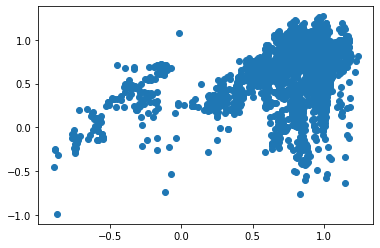

In [8]:
adistill, acom = [], []
for b in beam49:
    adistill.extend(b['distillscores'] )
    acom.extend(b['cometscores'])
plt.scatter(adistill, acom)

In [67]:
def manual_search():
    global weights
    for 

array([-2.04e+00, -2.50e-04,  1.00e-04,  1.00e-04,  1.00e-04])

(array([15., 62., 15.,  6.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.0917402 , -0.02910655,  0.03352709,  0.09616074,  0.15879438,
         0.22142803,  0.28406168,  0.34669532,  0.40932897,  0.47196261,
         0.53459626,  0.5972299 ,  0.65986355,  0.72249719,  0.78513084,
         0.84776449,  0.91039813,  0.97303178,  1.03566542,  1.09829907,
         1.16093271]),
 <BarContainer object of 20 artists>)

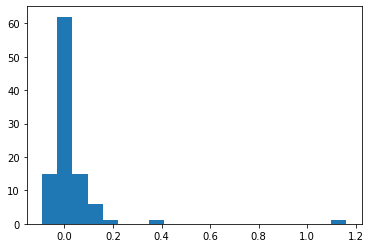

In [83]:
a = rerank_all(beam49, 10, "qescores")
b = rerank_all(beam49, 10, "rescores")
comp = get_comp_distr(b, a)
plt.hist(comp, bins =20)

In [84]:
print(sum(comp)/len(comp))

0.027135396971929782


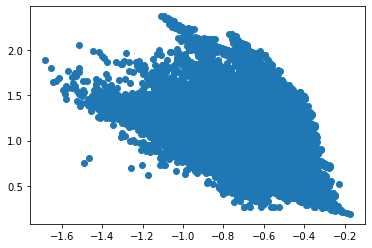

In [9]:
x, y = get_pairs_complete(lat4, "modelscores", "rescores")
  
plt.scatter(x, y)
plt.show()

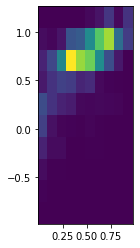

In [49]:
#x, y = get_pairs_complete(beam49, "modelscores", "cometscores")

heatmap, xedges, yedges = np.histogram2d(x, y, bins=(10, 10))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

(array([16., 27., 22., 15.,  9.,  4.,  4.,  2.,  0.,  2.]),
 array([0.47536054, 0.56476725, 0.65417396, 0.74358066, 0.83298737,
        0.92239407, 1.01180078, 1.10120748, 1.19061419, 1.2800209 ,
        1.3694276 ]),
 <BarContainer object of 10 artists>)

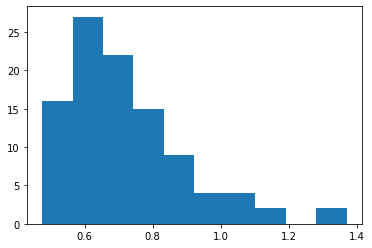

In [43]:
bdistr = all_topsco_distr(beam49, 20)
latdistr = all_topsco_distr(lat4, 20)
plt.hist(latdistr)

In [24]:
sum(latdistr)/len(latdistr)

0.7219551513372303

In [25]:
sum(bdistr)/len(bdistr)

0.4211500431189852

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

dev = "cuda:2"
mname = "facebook/mbart-large-50-one-to-many-mmt"
tokenizer = AutoTokenizer.from_pretrained(mname)
model = AutoModelForSeq2SeqLM.from_pretrained(mname)
tok = AutoTokenizer.from_pretrained(mname, src_lang='en_XX', tgt_lang='de_DE')
model.to(dev)

In [108]:
def sanity_beam(ind, lcode='de_DE', beams=4, mlen=80):
    
    model_inputs = tokenizer([beam49[ind]['src']], return_tensors="pt", truncation=True, padding=True).to(dev)
    outs = model.generate(
        **model_inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id[lcode],
        num_beams=beams,
        max_length=mlen, 
        num_return_sequences=beams,
        return_dict_in_generate=True,
        output_scores=True,
    )
    
    print(outs.sequences_scores)
    print(beam49[ind]['modelscores'])
    print(beam49[ind]['rescores'])
    inputs = tokenizer(beam49[ind]['src'], return_tensors="pt").to(dev)
    for c in beam49[ind]['cands']:
        #print(inputs)
        with tok.as_target_tokenizer():
            labels = tok([c], return_tensors="pt").to(dev)
        output = model(**inputs, labels=labels.input_ids)
        print(output.loss)
    mis = 0
    m = np.argsort(beam49[ind]['modelscores']).tolist()
    print(m)
    t = np.argsort(beam49[ind]['rescores']).tolist()
    t.reverse()
    print(t)
    return t==m

def sanity_lattice(ind, lcode='de_DE', beams=4, mlen=80):
    
    #print(outs.sequences_scores)
    #print(lat4[ind]['modelscores'])
    #print(lat4[ind]['rescores'])
    inputs = tokenizer(lat4[ind]['src'], return_tensors="pt").to(dev)
    for c in lat4[ind]['cands'][:10]:
        #print(inputs)
        with tok.as_target_tokenizer():
            labels = tok([c], return_tensors="pt").to(dev)
        output = model(**inputs, labels=labels.input_ids)
        #print(output.loss)
    m = np.argsort(lat4[ind]['modelscores']).tolist()
    #print(m)
    t = np.argsort(lat4[ind]['rescores']).tolist()
    t.reverse()
    #print(t)
    print(t[:5])
    print(m[-5:])
    return t[:5]==m[-5:]
    


In [ ]:
cnt = 0
for i in range(0, len(lat4)):
    print(i)
    if sanity_lattice(i):
            cnt+=1
print(cnt)

In [98]:
beam49[3]['modelscores']

[-0.4107227325439453,
 -0.4116992652416229,
 -0.41290998458862305,
 -0.4169265627861023]

In [ ]:


# forward pass
